# Projeto SPIRA
## Pré-processamento dos sinais de áudio
### Diminuição do ruído de fundo (ambiental)
#### Marcelo Queiroz - Reunião do projeto SPIRA em 24/06/2020

In [4]:
import io
import os
import math as m
import numpy as np
from urllib.request import urlopen
import scipy.io.wavfile as wavfile
import ctypes
import pyogg
import soundfile as sf
from imageio import imread
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import HBox, Dropdown, Output, Layout
from common.noisereduce import reduce_noise

ModuleNotFoundError: No module named 'librosa'

In [2]:
# abre sinal gravado em arquivo

# se arquivo wav, usar essa sintaxe:
#rate, x = wavfile.read(filename)

# se arquivo opus, usar essa função:
def opusfile_read(filename):
    opus_file = pyogg.OpusFile(filename)
    rate = opus_file.frequency
    bytes_per_sample = ctypes.sizeof(opus_file.buffer.contents)
    x = np.ctypeslib.as_array(
        opus_file.buffer,
        (opus_file.buffer_length//
         bytes_per_sample//
         opus_file.channels,
         opus_file.channels)
    )
    return rate, x

In [3]:
files = os.listdir('/opt/spira/dados/pacientes/audio/202020/')
files.sort()
openfiledialog = Dropdown(
    options=files,
    value=files[3],
    description='Arquivo:',
    disabled=False,
)

## Seleção do arquivo de entrada
##### (alguns exemplos interessantes: PTT-20200511-WA0005, PTT-20200511-WA0012 e PTT-20200511-WA0014)

In [4]:
display(openfiledialog)

Dropdown(description='Arquivo:', index=3, options=('PTT-20200511-WA0000.opus', 'PTT-20200511-WA0001.opus', 'PT…

In [5]:
filename = openfiledialog.value
rate, x = opusfile_read('/opt/spira/dados/pacientes/audio/202020/'+filename)

In [6]:
# pré-processamentos: elimina dc e ajusta faixa de amplitudes a [-1,+1]
# (obs: isso não é uma normalização, mas é necessário para permitir
#       o uso da opção normalize=False no widget ipd.Audio)

sample_depth = 8*x[0].itemsize # número de bits por amostra
x = x[:,0]-np.mean(x) # elimina dc
x = x/(2**(sample_depth-1)) # ajusta amplitudes para [-1,+1]

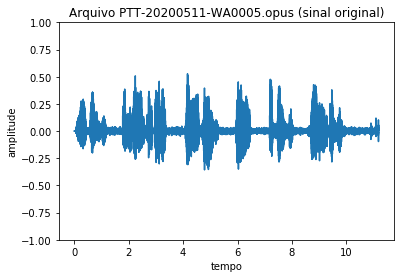

In [7]:
# inspeção visual e aural do sinal
plt.plot(np.arange(len(x))/rate,x);plt.title(f"Arquivo {filename} (sinal original)")
plt.xlabel("tempo");plt.ylabel("amplitude");plt.ylim([-1,1]);plt.show()
display(ipd.Audio(x.T, rate=rate, normalize=False))

## Seleção automática dos trechos de ruído
> - Calcula energia média (em dB) do sinal em função do tempo
> - Detecta o nível mínimo de ruído (noise floor)
> - Seleciona trechos com energia média 6dB acima do nível mínimo de ruído
> - Aplica filtro da maioria para "estabilizar" classificaçãp

In [8]:
# calcula a energia média (em dB) do sinal sobre janelas deslizantes
# devolve sinal edB e seu valor mínimo (noise floor)
def window_pow(sig, window_size=4096):
    sig2 = np.power(sig,2)
    window = np.ones(window_size)/float(window_size)
    edB = 10*np.log10(np.convolve(sig2, window))[window_size-1:]
    # corrige aberrações nas extremidades (trechos artificialmente silenciosos)
    imin = int(0.5*rate) # isola 500ms iniciais e finais 
    edBmin = min(edB[imin:-imin])
    edB = np.maximum(edB,edBmin)
    return edB, edBmin

In [9]:
# calcula envoltória de energia em dB do sinal
edB, edBmin = window_pow(x)

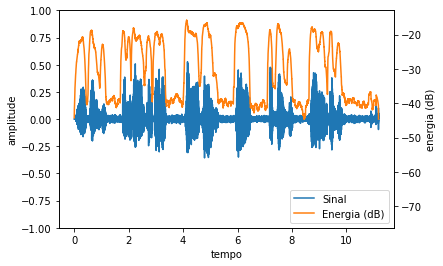

In [10]:
# visualiza sinal de áudio e energia em dB
fig, ax1 = plt.subplots();fig1 = ax1.plot(np.arange(len(x))/rate,x,label="Sinal")
ax1.set_ylim([-1,1]);ax1.set_xlabel(r"tempo");ax1.set_ylabel(r"amplitude")
ax2 = ax1.twinx();fig2 = ax2.plot(np.arange(len(edB))/rate,edB,"tab:orange",label="Energia (dB)")
m = min(edB);M=max(edB)-m;ax2.set_ylim([m-1.1*M,m+1.1*M]);ax2.set_ylabel(r"energia (dB)")
figs = fig1+fig2;labels = [l.get_label() for l in figs];plt.legend(figs,labels,loc="lower right")
plt.show()

In [11]:
# Filtro da mediana 1D para vetores booleanos, sobre janelas de 2*N+1 elementos
def boolean_majority_filter(sig_in,N):
    # cria uma cópia do vetor de entrada
    sig_out = sig_in.copy()
    # coloca N valores True de sentinela antes e depois do vetor sig_in
    # (True força maior chance das bordas serem consideradas ruído, o que é + comum)
    sig_pad = np.concatenate((np.ones(N),sig_in,np.ones(N+1)))
    # contadores de "votos"
    nTrue = 0
    nFalse = 0
    # inicialização da contagem (corresponderá à contagem da situação em sig[0])
    for i in range(2*N+1):
        if sig_pad[i]:
            nTrue += 1
        else:
            nFalse += 1
    # aplica filtro da maioria nos índices de sig_in/out: a cada índice i, o resultado
    # é o voto da maioria na janela sig_in[i-N:i+N+1] (contendo 2*N+1 elementos)
    # que corresponde aos índices sig_pad[i:i+2*N+1] no vetor com sentinelas
    for i in range(len(sig_out)):
        sig_out[i] = nTrue>nFalse
        # subtrai o voto retirado (primeiro da janela deslizante atual)
        # se possível, tira um voto do sinal já *filtrado*
        # (aproveita estabilidade à esquerda)
        if i>=N:
            nout = sig_out[i-N]
        else: # se não for possível, tira um "True" do vetor com sentinelas
            nout = sig_pad[i]
        if nout:
            nTrue -=1
        else:
            nFalse -= 1
        # inclui o voto novo, que é o último da janela deslizante
        # referente ao próximo índice (i+1) em sig
        if sig_pad[i+1+2*N]:
            nTrue += 1
        else:
            nFalse += 1
    return sig_out

In [12]:
# seleção de trechos do sinal sig contendo ruído, devolve sinal booleano
def noise_sel(sig,edB,edBmin,noise_threshold=6):
    # seleciona frames com rms próxima do nível mínimo
    inoise_pre = edB<edBmin+noise_threshold
    # aplica filtro da mediana (voto de maioria) para eliminar
    # trechos menores do que 0.2s
    inoise = boolean_majority_filter(inoise_pre,int(0.2*rate))
    return inoise, inoise_pre    

In [13]:
# aplica seleção de frames ao sinal de entrada
xnoise, xnoisep = noise_sel(x,edB,edBmin)

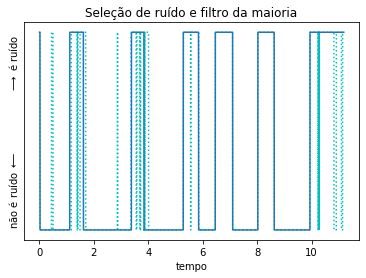

In [14]:
# visualiza janela de seleção de ruído antes e depois do filtro da maioria
fig = plt.plot(np.arange(len(xnoise))/rate,xnoisep,"c:")
plt.plot(np.arange(len(xnoise))/rate,xnoise)
plt.xlabel("tempo");plt.yticks([],"")
plt.ylabel(r"não é ruído $\longleftarrow\quad\quad\quad\quad\quad\quad\longrightarrow$ é ruído")
plt.title("Seleção de ruído e filtro da maioria");plt.show()

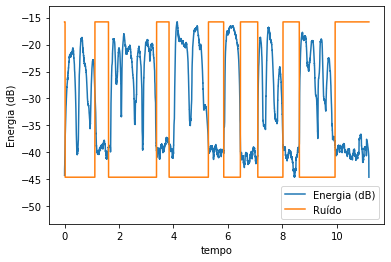

In [15]:
# visualiza energia em dB e seleção de ruído
plt.plot(np.arange(len(edB))/rate,edB,label="Energia (dB)")
plt.plot(np.arange(len(xnoise))/rate,(max(edB)-edBmin)*xnoise+edBmin,label="Ruído")
plt.xlabel("tempo");plt.ylabel("Energia (dB)");
m = min(edB);M=max(edB)-m;plt.ylim([m-0.3*M,m+1.1*M]);
plt.legend(loc="lower right");plt.show()

In [16]:
# recorta trechos de áudio do sinal identificados como ruído
noise = x[xnoise]

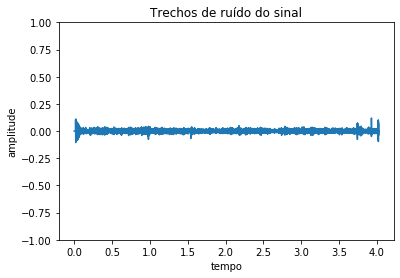

In [17]:
# inspeção visual/aural dos trechos de ruído
plt.plot(np.arange(len(noise))/rate,noise)
plt.title("Trechos de ruído do sinal")
plt.xlabel("tempo");plt.ylabel("amplitude");plt.ylim([-1,1]);plt.show()
display(ipd.Audio(noise.T, rate=rate, normalize=False))

## Filtragem do ruído por *Gating* (*Supressão*)
> - Modelagem Gaussiana da distribuição espectral do ruído
> - Constrói representação tempo-frequência (STFT) do sinal
> - Estabelece um limiar para considerar um elemento $(t,f)$ do plano como relevante (sinal)
$$(t,f)\text{ é ruído} \iff \text{STFT}(t,f) > \mu+K\sigma$$
> - Suavização da máscara binária dos trechos relevantes
> - Ressíntese do produto sinal $\times$ máscara

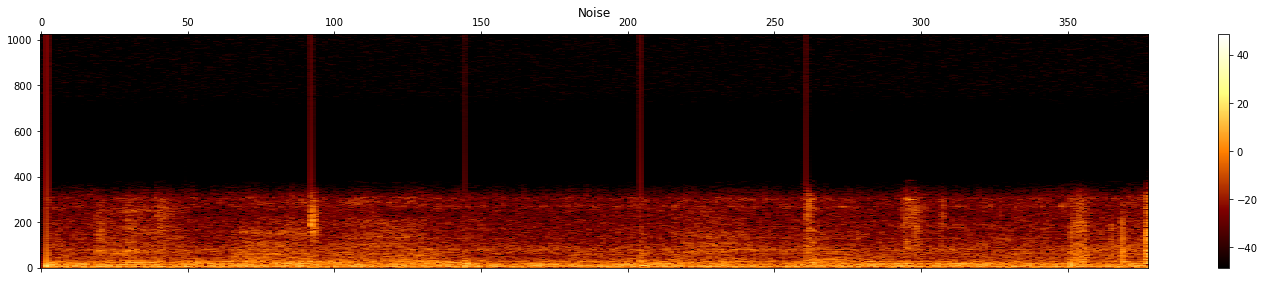

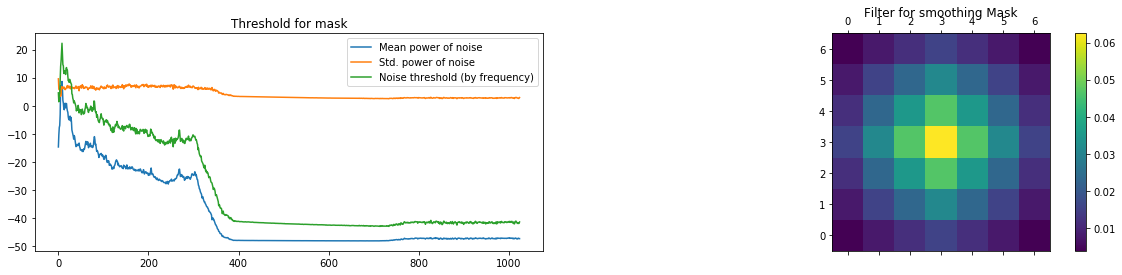

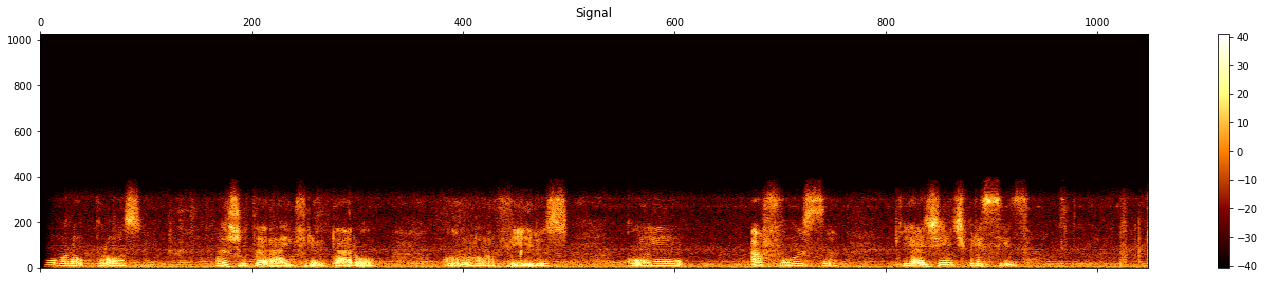

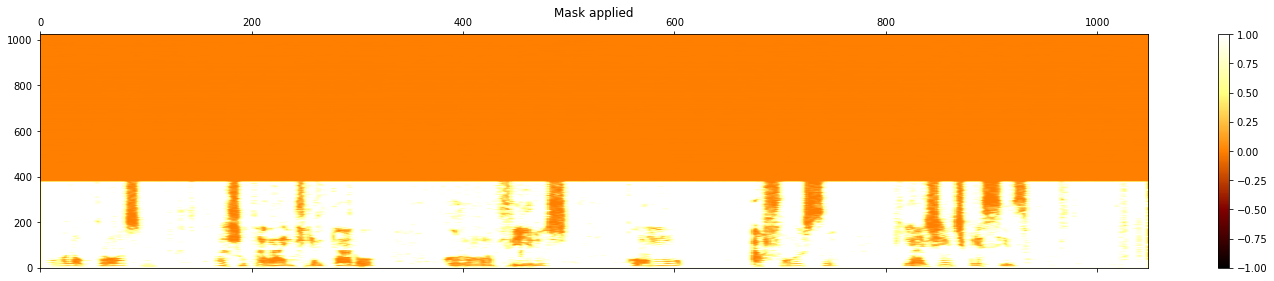

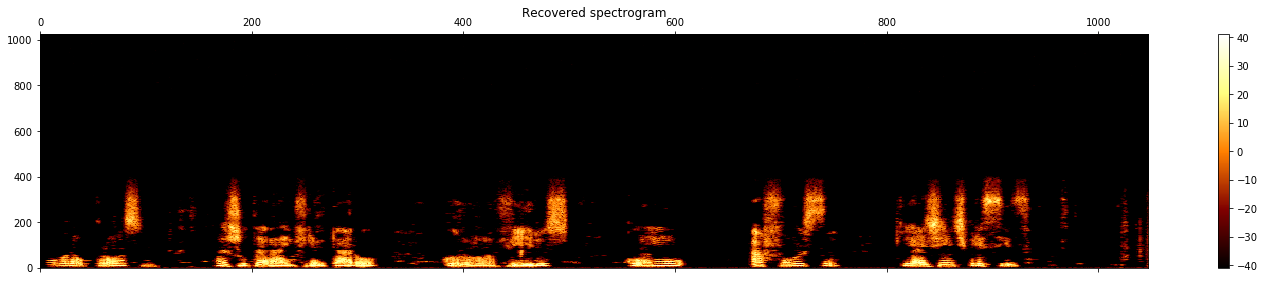

In [18]:
y, ε = reduce_noise(audio_clip=x, noise_clip=noise, n_grad_freq=3, n_grad_time=3, n_std_thresh=2, prop_decrease=1.0, verbose=True)

In [19]:
# ajusta faixa de saída dos resultados (caso ultrapassem -1...+1, não deveriam)
y /= max(max(y),-min(y),1)
ε /= max(max(ε),-min(ε),1)

In [20]:
# Jeito legal de organizar os widgets, mas não funciona no nbconvert+reveal
audio_widgets = []
for sig in [x, y, ε]:
    out = Output()
    with out:
        display(ipd.Audio(sig.T, rate=rate, normalize=False))
    audio_widgets.append(out)
HBox(audio_widgets)

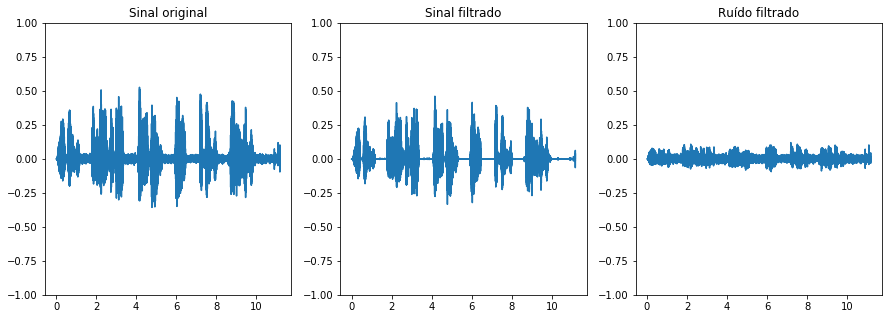

Sinal original

Sinal filtrado

Ruído filtrado

In [21]:
sig = [x, y, ε];sig_names = ["Sinal original","Sinal filtrado","Ruído filtrado"]
fig,ax = plt.subplots(1,3,figsize=(15, 5))
for i in range(len(sig)):
    ax[i].plot(np.arange(len(sig[i]))/rate,sig[i]);ax[i].set_title(sig_names[i]);ax[i].set_ylim([-1,1])
plt.show()
for i in range(len(sig)):
    display(ipd.Markdown(sig_names[i]),ipd.Audio(sig[i].T, rate=rate, normalize=False))